In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow import keras
from uproot_io import Events, View

# Building a CNN for event classification.

We're only using **perfect reconstruction** (cheated files) for this.

1. Need to obtain the truth record for each event, 0 for CC_mu, 1 for CC_e and 2 for NC_x. 


In [2]:
# the data
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [3]:
event_numbers = np.array(list(set(events.event_number)))
event_numbers, len(event_numbers)

(array([   0,    1,    2, ..., 9307, 9308, 9309]), 9310)

# Labelling the events

In [4]:
def labelling():
    label = []
#     bad = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])
                
#         if 13 in mcp and 11 in mcp:
#             bad.append(n)
#             label.append(3)
        
        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

In [5]:
labels = labelling()

9310


((array([3512.,    0.,    0.,    0.,    0., 3715.,    0.,    0.,    0.,
         2083.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <BarContainer object of 10 artists>),
 None)

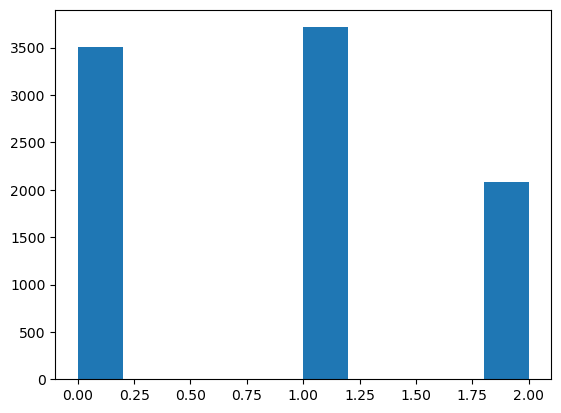

In [6]:
plt.hist(labels), print(len(labels))

In [7]:
def oneHotLabelling():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [8]:
one_hot_labels = oneHotLabelling()

# Making the images

In [6]:
view_w = View(events, "w")

In [7]:
def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

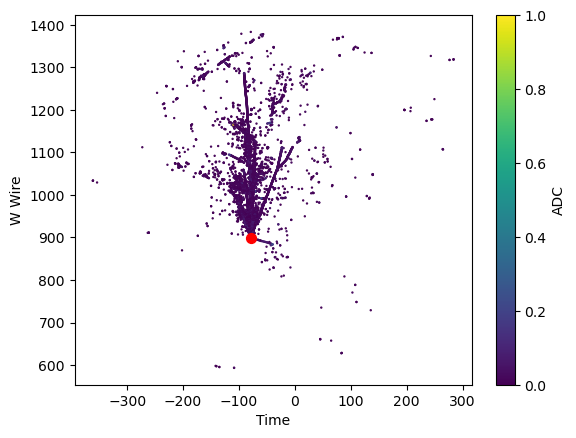

In [8]:
plot_w_event(4223)

In [9]:
def image(n):
    
    images = []
    
#    for n in event_numbers:
    
    x = view_w.x[n]
    z = view_w.z[n]
    adc = view_w.adc[n]

    matrix_size = 128
    matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)

    #matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
    #images.append(matrix)


    # Display the pixelated image
    plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
    plt.colorbar()
    #plt.title('Pixelated Image of Energy')
    plt.show()
    
    #return np.stack(images)

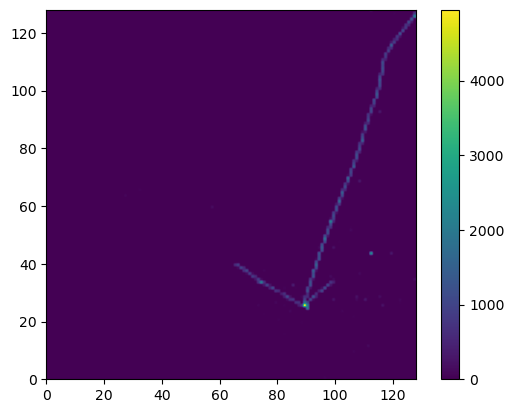

In [10]:
#images = image()
#print(images)
image(333)

In [11]:
def imagenew(n):
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        vx = view_w.true_vtx_x[n]
        vz = view_w.true_vtx_z[n]

        matrix_size = 256 
        minusx = np.floor(np.mean(x))-150
        plusx = np.floor(np.mean(x))+150
        minusz = np.floor(np.mean(z))-150
        plusz = np.floor(np.mean(z))+150

        if vx < minusx:
            minusx = np.floor(vx)-25
            plusx = np.floor(vx)+275
        if vx > plusx:
            minusx = np.floor(vx)-275
            plusx = np.floor(vx)+25
        if vz < minusz:
            minusz = np.floor(vz)-25
            plusz = np.floor(vz)+275
        if vz > plusz:
            minusz = np.floor(vz)-275
            plusz = np.floor(vz)+25

        #range=[[np.floor(np.mean(x))-250, np.floor(np.mean(x))+250], [vz-250, vz+250]]

        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[minusx, plusx], [minusz, plusz]], weights=adc)
        matrix = (matrix > 0).astype(int)

        matrix = np.floor(matrix).astype(np.uint8).reshape(256, 256, 1)
        images.append(matrix)


    # Display the pixelated image
    #plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 256, 0, 256])
    #plt.colorbar()
    #plt.title('Pixelated Image of Energy')
    #plt.show()
    
    return np.stack(images)

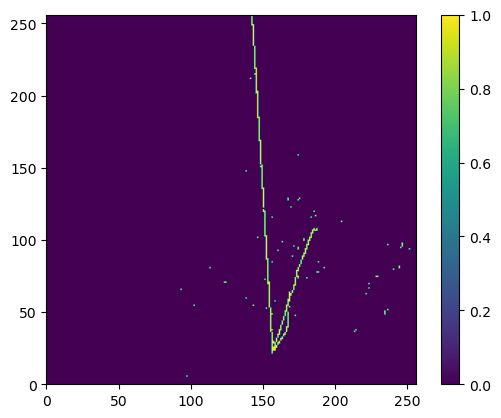

In [20]:
imagenew(16)

In [121]:
images = imagenew()

In [122]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")
len(testing)

2793

In [123]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [124]:
print(y_train)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [125]:
num_classes = 3

# The CNN

In [126]:
input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 516128)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1548387   
                                                           

In [127]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [128]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [129]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/5
51/51 [==============================] - 80s 1s/step - loss: 0.8707 - accuracy: 0.6263 - val_loss: 0.7019 - val_accuracy: 0.7304
Epoch 2/5
51/51 [==============================] - 80s 2s/step - loss: 0.3864 - accuracy: 0.8808 - val_loss: 0.5757 - val_accuracy: 0.7999
Epoch 3/5
51/51 [==============================] - 81s 2s/step - loss: 0.2024 - accuracy: 0.9490 - val_loss: 0.5734 - val_accuracy: 0.8145
Epoch 4/5
51/51 [==============================] - 81s 2s/step - loss: 0.1134 - accuracy: 0.9765 - val_loss: 0.6028 - val_accuracy: 0.8238
Epoch 5/5
51/51 [==============================] - 84s 2s/step - loss: 0.0700 - accuracy: 0.9882 - val_loss: 0.6282 - val_accuracy: 0.8246


In [130]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 7s 297ms/step
Number of images that were incorrectly classified = 490


In [131]:
accuracy = (len(testing)-len(incorrect_indices))/len(testing)
print(accuracy)

0.8245614035087719


Incorrect classification for image/event 145 4223 : predicted = 0 with true = 1


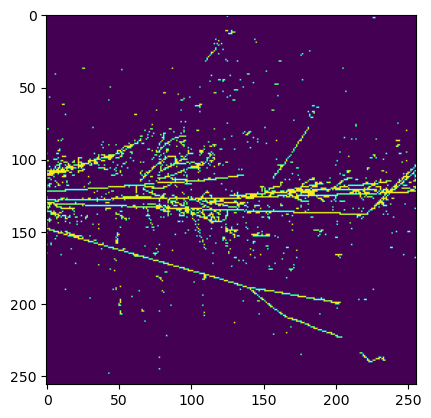

In [162]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 26
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
index = incorrect_indices[im][0]
print('Incorrect classification for image/event',incorrect_indices[im][0], testing[index],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [139]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


In [140]:
conf_matrix_decimals

array([[0.8503937 , 0.08956693, 0.06003937],
       [0.03933566, 0.86101399, 0.09965035],
       [0.09794629, 0.18483412, 0.71721959]])

Text(50.722222222222214, 0.5, 'True Label')

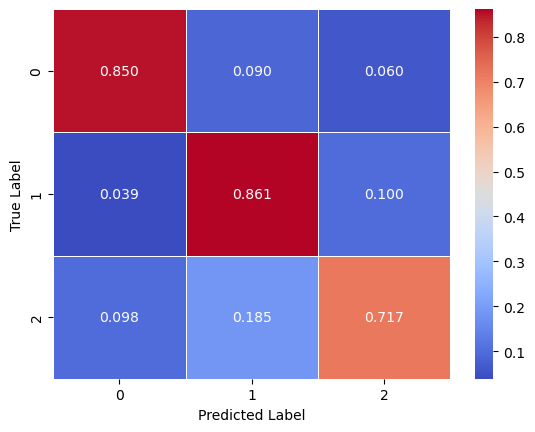

In [141]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')